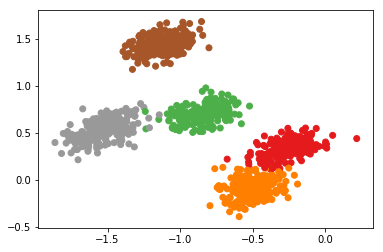

In [1]:
import variational_bayes as vb
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm_notebook
import scipy.stats
%matplotlib inline

np.random.seed(9)
num_samples = 1000
num_groups = 5

z = np.random.choice(num_groups, num_samples)
group_mean = np.random.normal(0, 1, (num_groups, 2))
group_precision = scipy.stats.wishart.rvs(100, [[1, -.5], [-.5, 1]], num_groups)
cholesky = np.linalg.cholesky(np.linalg.inv(group_precision))

x = group_mean[z] + np.einsum('iab,ia->ib', cholesky[z], np.random.normal(0, 1, (num_samples, 2)))

plt.scatter(*x.T, c=z, cmap='Set1')

In [2]:
def mixture_model(num_groups):
    # Set up the factors
    q_mean = vb.MultiNormalDistribution(np.random.normal(0, 1e-3, (num_groups, 2)), 
                                        np.ones((num_groups, 1, 1)) * np.eye(2) * 1e-3)
    q_precision = vb.WishartDistribution(2 * np.ones(num_groups), np.ones((num_groups, 1, 1)) * np.eye(2) * 1e-3)
    q_z = vb.CategoricalDistribution(np.random.dirichlet(1000 * np.ones(num_groups), num_samples))
    
    # Evaluate the likelihood
    mixture_likelihood = vb.MixtureDistribution(
        q_z, vb.MultiNormalDistribution(q_mean, q_precision)
    ).likelihood(x[:, None])
    
    mean_prior = vb.MultiNormalDistribution(np.ones(2), 1e-4 * np.eye(2)).likelihood(q_mean)
    precision_prior = vb.WishartDistribution(2, 0.2 * np.eye(2)).likelihood(q_precision)
    z_prior = vb.CategoricalDistribution(np.ones(num_groups) / num_groups).likelihood(q_z)

    return vb.Model({'mean': q_mean, 'precision': q_precision, 'z': q_z}, 
                    [mixture_likelihood, z_prior, mean_prior, precision_prior])

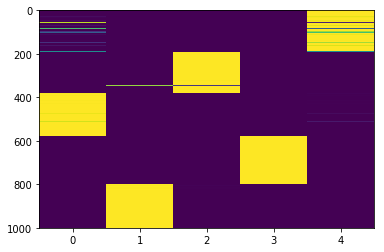

In [3]:
model = mixture_model(num_groups)
elbo, converged = model.update(200, tqdm=tqdm_notebook)

plt.imshow(model['z'].mean[np.argsort(z)], aspect='auto')

In [6]:
# gitignore
model._likelihoods[0].distribution.parameters

{'mean': MultiNormalDistribution@0x11c208278(mean=array((5, 2), float64), precision=array((5, 2, 2), float64)),
 'precision': WishartDistribution@0x11c208710(shape=array((5,), float64), scale=array((5, 2, 2), float64)),
 'z': CategoricalDistribution@0x11a154198(proba=array((1000, 5), float64))}

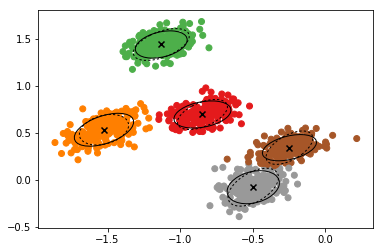

In [4]:
ax = plt.gca()
ax.scatter(*x.T, c=np.argmax(model['z'].mean, axis=1), cmap='Set1')
ax.scatter(*model['mean'].mean.T, marker='x', color='k')
for i in range(num_groups):
    ax.add_artist(vb.ellipse_from_cov(
        model['mean'].mean[i], 
        np.linalg.inv(model['precision'].mean[i]),
        facecolor='none', edgecolor='k'
    ))
    ax.add_artist(vb.ellipse_from_cov(
        model['mean'].mean[i], 
        np.linalg.inv(group_precision[i]),
        facecolor='none', edgecolor='k', ls=':'
    ))

Widget Javascript not detected.  It may not be installed or enabled properly.


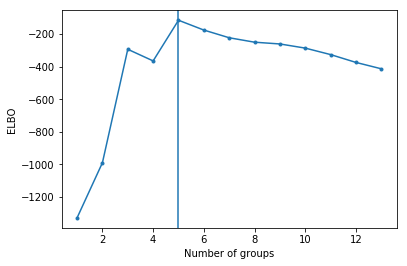

In [5]:
num = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
elbos = []

for n in tqdm_notebook(num):
    model = mixture_model(n)
    elbo, _ = model.update(200)
    elbos.append(elbo[-1])
    
plt.plot(num, elbos, marker='.')
plt.axvline(num_groups)
plt.ylabel('ELBO')
plt.xlabel('Number of groups')